In [1]:
import numpy as np
import dimod
import dwave_networkx as dnx
import networkx as nx
import minorminer
import minorminer.layout as mml
%matplotlib inline
import dwave.inspector
import math
from datetime import datetime
from pathlib import Path  
import pandas as pd
import os

from matplotlib.pyplot import subplots
from matplotlib.table import Table
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools  



def Reverse(tup):
    newtup=(tup[1],tup[0])
    return newtup

In [2]:

from dwave.system import DWaveSampler

# Use a D-Wave system as the sampler
f = open("../token.txt", "r")
#sampler = DWaveSampler(solver=dict(topology__type='chimera'),token=f.read())
sampler = DWaveSampler(solver=dict(topology__type='zephyr'),token=f.read())

print("QPU {} was selected.".format(sampler.solver.name))

QPU Advantage2_prototype1.1 was selected.


In [3]:
edges_chain = [(51, 532), (55, 532), (528, 55), (528, 51)]
edges_dominant = [(520, 51), (520, 55), (43, 528), (43, 532), (524, 51), (524, 55), (47, 528), (47, 532)]

all_edges = edges_chain + edges_dominant
ancilla_sites = [520, 43, 524, 47]
qubit_sites = [51, 532, 528, 55]

ancilla_sites + qubit_sites
J_dict = {}
for e in all_edges:
    if e in edges_chain:
        jval = -2
        if e in sampler.edgelist:
            J_dict.update({e:jval})
        elif Reverse(e) in sampler.edgelist:
            J_dict.update({Reverse(e):jval})
        else:
            print("problem with ", e)
    elif e in edges_dominant:
        jval = -1/2
        if e in sampler.edgelist:
            J_dict.update({e:jval})
        elif Reverse(e) in sampler.edgelist:
            J_dict.update({Reverse(e):jval})
        else:
            print("problem with ", e)

all_sites = ancilla_sites + qubit_sites
h_dict = {}
for i in all_sites:
    if i in ancilla_sites:
        h_dict.update({i:5/8})
    elif i in qubit_sites:
        h_dict.update({i:-1/2})

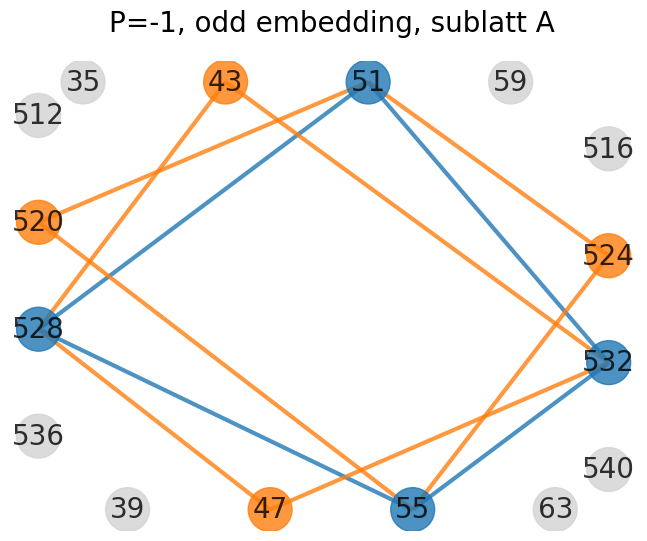

In [4]:
sites = []
for ed in all_edges:
    sites.append(ed[0])
    sites.append(ed[1])
res = [*set(sites)]
#print(res)

all_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
edges_draw = [key for key in J_dict.keys()]
edge_colors = []
for ed in edges_draw:
    if ed in edges_chain or Reverse(ed) in edges_chain:
        edge_colors.append(all_colors[0])
    else:
        edge_colors.append(all_colors[1])

absent = [512, 536, 35, 59, 540, 516, 39, 63]
res_v2 = res + absent 

node_colors = []
qubits_measure =  qubit_sites #majority rule
for site in res_v2:
    if site in qubits_measure:
        node_colors.append(all_colors[0])
    elif site in absent:
        node_colors.append('#D3D3D3')
    else:
        node_colors.append(all_colors[1])

G = dnx.zephyr_graph(4)
plt.ion()
plt.axis("off")
plt.title("P=-1, odd embedding, sublatt A", x=0.5, y=1.2, fontsize = 20)
dnx.draw_zephyr(G, nodelist = res_v2, width = 3, node_size = 1000,
 edgelist = edges_draw, with_labels = True, node_color = node_colors,
  font_size = 20, alpha = 0.8, edge_color = edge_colors)

In [12]:
J_dict

{(51, 532): -2,
 (55, 532): -2,
 (55, 528): -2,
 (51, 528): -2,
 (51, 520): -0.5,
 (55, 520): -0.5,
 (43, 528): -0.5,
 (43, 532): -0.5,
 (51, 524): -0.5,
 (55, 524): -0.5,
 (47, 528): -0.5,
 (47, 532): -0.5}

In [11]:
h_dict

{520: 0.625,
 43: 0.625,
 524: 0.625,
 47: 0.625,
 51: -0.5,
 532: -0.5,
 528: -0.5,
 55: -0.5}

In [13]:
#run it
run_true_or_false = True
if run_true_or_false:
    num_reads = 200
    response = sampler.sample_ising(h = h_dict, J=J_dict,
                                                num_reads=num_reads,
                                                annealing_time=100,
                                                answer_mode="raw", num_spin_reversal_transforms = 10)

    #dwave.inspector.show(response)


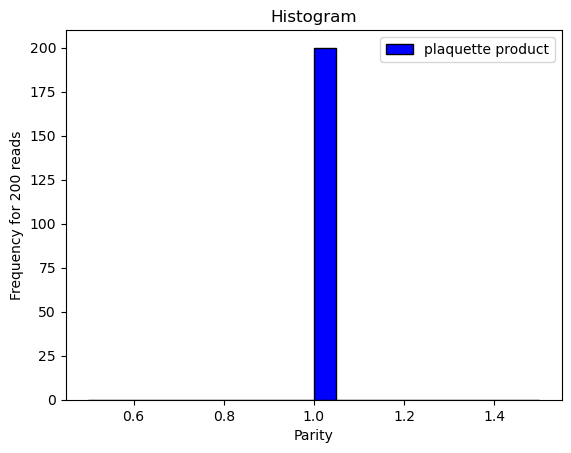

In [14]:
#the index of the plaquette qubit
inds_qb_plaquettes = []
qubits_measure =  qubit_sites #majority rule
for j in qubits_measure:
    inds_qb_plaquettes.append(response.variables.index(j))

plaq_values = []
for resp in response.record:
    plaq_values.append(np.prod(resp[0][inds_qb_plaquettes]))
#plaq_values

# Create histogram
plt.hist(np.array(plaq_values), bins=20, edgecolor='black', color = 'blue', label = 'plaquette product')

# Customize labels and title
plt.xlabel('Parity')
plt.ylabel('Frequency for 200 reads')
plt.title('Histogram')
plt.legend()
# Display the histogram
plt.show()



# are the spectrum the same?